In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
##################################################
## ============Summary=========================
## Course: SEIS745 Data Lake Engineering 
## Title: Flight Delay Analysis - Final Project
##
## Purpose: 
## The project will be completed using one or more datasets of your choosing.  
## You will architect, design, and implement a solution that performs data collection, preparation, analysis, and simple visualization of that dataset. 
## At the conclusion of the project, you will submit code artifacts and documentation for your solution.
##
## Date: 2024-05-13
## Author 01: Vernekar, Saloni Satish
## ==========Process Steps=====================
##
## SECTION 01: Notebook Configuration
## Step 01: Import Packages
##
##
## SECTION 02: Data Collection
## Step 01: Import Parquet Files from S3
## Step 02: Count the number of Rows for all the parquet files
##
##
## SECTION 03: Data Preparation
## Step 01 : Preparing the data 
## Step 02: Remove null values from Departure time
## Step 03: Remove and clean valuues for Arrival time 
##
## SECTION 04: Data Analytics and Visualization
##
## Step 01: Analytics and Visualization for flights delayed by year
## Step 02: Analytics and Visualization for flights delayed by Airline for the top 20 Airline operators
## Step 03: Analytics for Percentage calculation of delays in Southwest airlines
## Step 04: Analytics and Visualization for flights delayed by Month
## Step 05: Distribution of flights by Delay upto 3 Hours
## Step 06: Analytics to calculate Delays upto 30 mins
## Step 07: Analytics to calculate total percent of Delayed flights in the dataset
## Step 08: Delay Group Clustering
## Step 09: Analytics and Visualization for Treemap of Delays by Year 
## Step 10: Analytics and Visualization for Treemap of Delays by Month
##
##
##
##
## ==================Resources================================
## 1.https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022
## 2.https://docs.databricks.com/
## 3.https://docs.aws.amazon.com/index.html
## 
#################################################4

In [0]:
##################################################
## SECTION 01: Notebook Configuration
##
## Step 01: Import Packages
##################################################

from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from functools import reduce
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.functions import month
from pyspark.sql.functions import col, udf, count, , when, expr
from pyspark.sql.types import StringType
from pyspark.sql import functions as F
from pyspark.sql.functions import desc
from pyspark.sql.types import StringType
from pyspark.sql.types import StructField, StructType, IntegerType, BooleanType, DataType, DecimalType
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")



## Create session 
spark=  SparkSession.builder.appName("Flight Status Prediction").getOrCreate()

In [0]:
##################################################
## SECTION 02: Data Collection
##
## Step 01: Import Parquet Files from S3
##################################################


df_2018=spark.read.format("parquet").option("header","true").option("inferschema","true").load("s3://datalakefinalproject/Combined_Flights_2018.parquet")
df_2019=spark.read.format("parquet").option("header","true").option("inferschema","true").load("s3://datalakefinalproject/Combined_Flights_2019.parquet")
df_2020=spark.read.format("parquet").option("header","true").option("inferschema","true").load("s3://datalakefinalproject/Combined_Flights_2020.parquet")
df_2021=spark.read.format("parquet").option("header","true").option("inferschema","true").load("s3://datalakefinalproject/Combined_Flights_2021.parquet")
df_2022=spark.read.format("parquet").option("header","true").option("inferschema","true").load("s3://datalakefinalproject/Combined_Flights_2022.parquet")



In [0]:
##################################################
## SECTION 02: Data Collection
##
## Step 02: Count the number of Rows for all the parquet files
##################################################

rows_2018= df_2018.count()
rows_2019= df_2019.count()
rows_2020= df_2020.count()
rows_2021= df_2021.count()
rows_2022= df_2022.count()
total= rows_2018+rows_2019+rows_2020+rows_2021+rows_2022
print(f"The dataset has {total:.2f} number of rows")

The dataset has 29193782.00 number of rows


In [0]:
##################################################
## SECTION 03: Data Preparation
## 
## Step 01 : Preparing the data
##################################################

# List of parquet files
parquet_files = ["s3://datalakefinalproject/Combined_Flights_2018.parquet", 
                 "s3://datalakefinalproject/Combined_Flights_2019.parquet", 
                 "s3://datalakefinalproject/Combined_Flights_2020.parquet", 
                 "s3://datalakefinalproject/Combined_Flights_2021.parquet", 
                 "s3://datalakefinalproject/Combined_Flights_2022.parquet"]

# Define column subset
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    "Year",
    "Month",
]

# Read parquet files into DataFrame
dfs = []
for file in parquet_files:
    df = spark.read.parquet(file)
    dfs.append(df.select(column_subset))

# Concatenate DataFrames
flights = reduce(lambda df1, df2: df1.union(df2), dfs)

# Convert columns to categorical
cat_cols = ["Airline", "Origin", "Dest", "OriginStateName", "DestStateName"]
for col_name in cat_cols:
    flights = flights.withColumn(col_name, col(col_name).cast(StringType()))

# Show DataFrame schema
flights.printSchema()


root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: long (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- OriginAirportID: long (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestAirportID: long (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)



In [0]:
##################################################
## SECTION 03: Data Preparation
##
## Step 02: Remove null values from Departure time
## Step 03: Remove and clean values for Arrival time 
##################################################

# Dropping duplicate rows
flights = flights.dropDuplicates()

# Remove rows with null departure or arrival time
flights = flights.filter(col('DepTime').isNotNull() & col('ArrTime').isNotNull())

# Remove null values from departure delay column
flights = flights.filter(col('DepTime') != '2400')
flights = flights.withColumn('DepTime', col('DepTime').cast(StringType()))
flights = flights.withColumn('CRSDepTime', col('CRSDepTime').cast(StringType()))
flights = flights.withColumn('DepTimeDateTime', expr("to_timestamp(DepTime, 'HHmm')"))
flights = flights.withColumn('CRSDepTimeDateTime', expr("to_timestamp(CRSDepTime, 'HHmm')"))
flights = flights.withColumn('DepDelay', (col('DepTimeDateTime').cast("long") - col('CRSDepTimeDateTime').cast("long")) / 60)
flights = flights.withColumn('DepDelayMinutes', when(col('DepDelay') > 0, col('DepDelay')).otherwise(0))
flights = flights.drop('DepTimeDateTime', 'CRSDepTimeDateTime')

# Remove null values from arrival delay column
flights = flights.filter(col('ArrTime') != '2400')
flights = flights.withColumn('ArrTime', col('ArrTime').cast(StringType()))
flights = flights.withColumn('CRSArrTime', col('CRSArrTime').cast(StringType()))
flights = flights.withColumn('ArrTimeDateTime', expr("to_timestamp(ArrTime, 'HHmm')"))
flights = flights.withColumn('CRSArrTimeDateTime', expr("to_timestamp(CRSArrTime, 'HHmm')"))
flights = flights.withColumn('ArrDelay', (col('ArrTimeDateTime').cast("long") - col('CRSArrTimeDateTime').cast("long")) / 60)
flights = flights.withColumn('ArrDelayMinutes', when(col('ArrDelay') > 0, col('ArrDelay')).otherwise(0))
flights = flights.drop('ArrTimeDateTime', 'CRSArrTimeDateTime')

# Remove null values from Taxi In/Taxi out columns
flights = flights.filter(col('TaxiIn').isNotNull() & col('TaxiOut').isNotNull())

# Show DataFrame schema
flights.printSchema()


root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: long (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: string (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- OriginAirportID: long (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestAirportID: long (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: string (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DepDelay: double

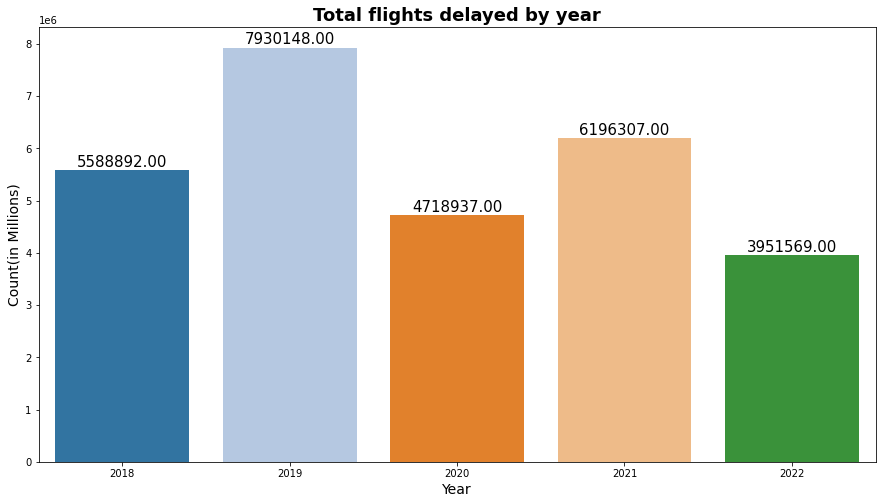

In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 01: Analytics and Visualization for flights delayed by year
##################################################


# Flight count per year
year_counts = flights.groupBy("Year").count().orderBy("Year")
year_counts_pd = year_counts.toPandas()


# Defining the plot size
plt.figure(figsize=(15, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(data=year_counts_pd, x= "Year", y="count",palette='tab20')
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
  plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
 
# Setting the label for x-axis
plt.xlabel("Year", size=14)
 
# Setting the label for y-axis
plt.ylabel("Count(in Millions)", size=14)
 
# Setting the title for the graph
plt.title("Total flights delayed by year", fontsize=18, color='Black',fontweight='bold', loc = 'center')
 
# Finally showing the plot
plt.show()


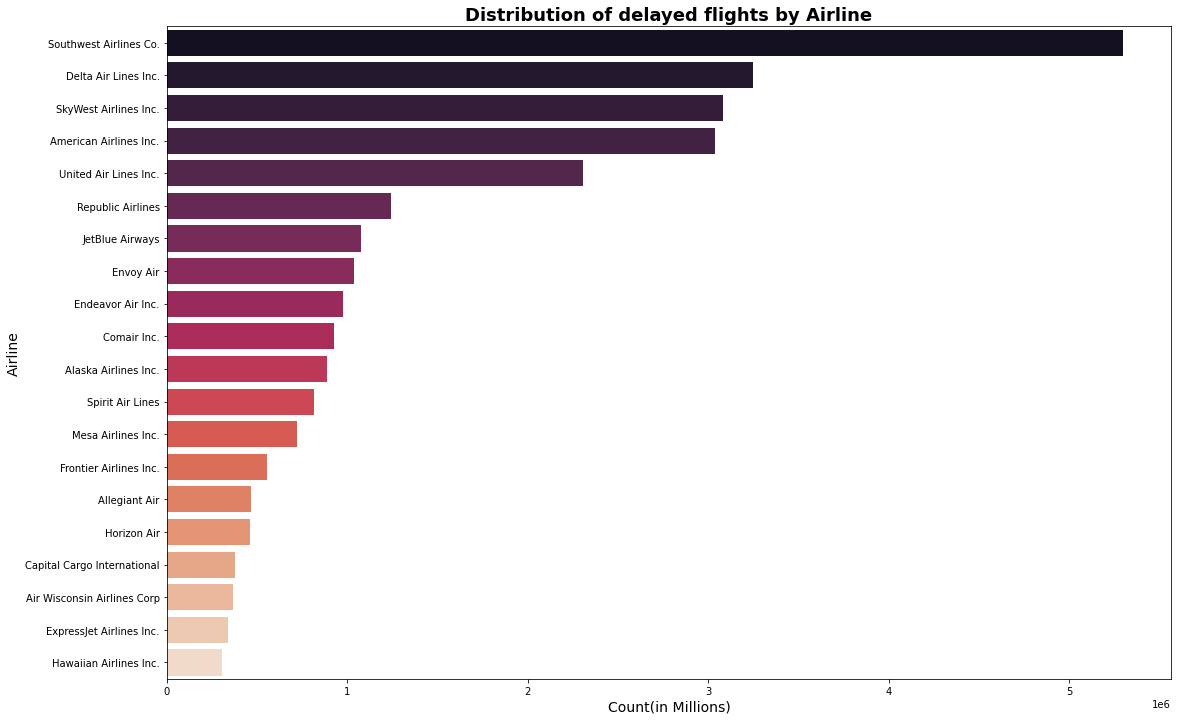

In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 02: Analytics and Visualization for flights delayed by Airline for the top 20 Airline operators
##################################################

Airline_type=flights.groupBy('Airline').count().orderBy(desc("count"))
Airline_top_20 = Airline_type.limit(20)
Airline_top_20_pd= Airline_top_20.toPandas()


# Defining the plot size
plt.figure(figsize=(18, 12))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(data=Airline_top_20_pd, x= "count", y="Airline",palette='rocket',orient='h')
  
# Setting the label for x-axis
plt.xlabel("Count(in Millions)", size=14)
 
# Setting the label for y-axis
plt.ylabel("Airline", size=14)
 
# Setting the title for the graph
plt.title("Distribution of delayed flights by Airline", fontsize=18, color='Black',fontweight='bold', loc = 'center')
# Finally showing the plot
plt.show()


In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 03: Analytics for Percentage calculation of delays in Southwest airlines
##################################################

company = "Southwest Airlines Co."

# Filter flights for the specific airline
company_flights = flights.filter(col('Airline') == company)


# Count total delays for the company
total_delays_company = company_flights.filter(col('DepDelayMinutes') > 0).count()

# Count total flights for the company
total_flights_company = company_flights.count()

# Calculate percentage delay
percentage_delay = (total_delays_company / total_flights_company) * 100

print(f"There is a {percentage_delay:.2f} percent chance that your flight will be delayed if you are travelling on a Southwest flight") 

There is a 37.69 percent chance that your flight will be delayed if you are travelling on a Southwest flight


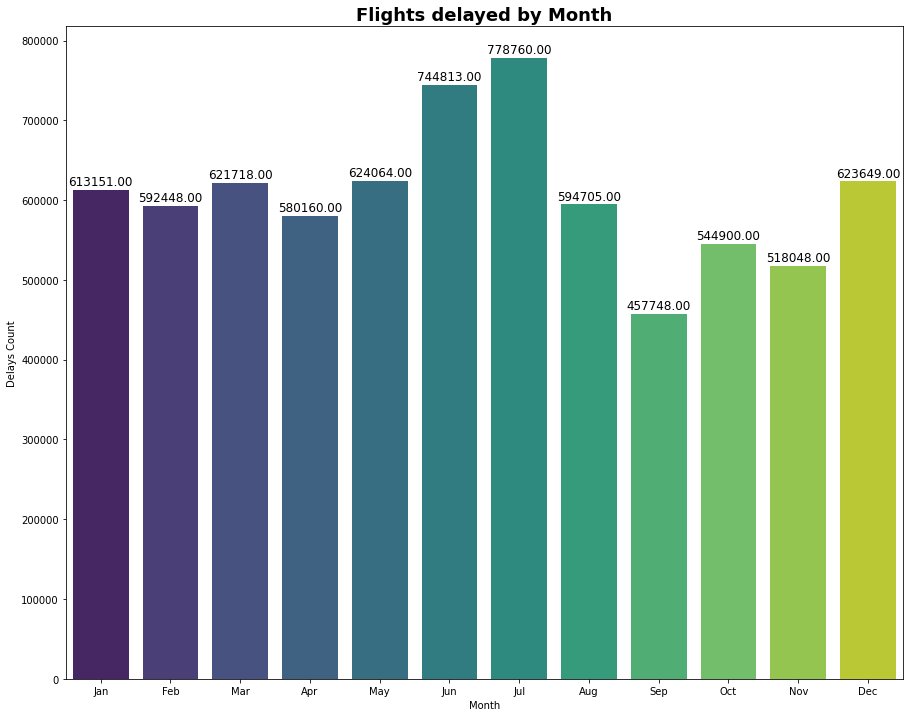

In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 04: Analytics and Visualization for flights delayed by Month
##################################################

# Filtering flights with departure delay > 0
delays_per_month = flights.filter(col('DepDelay') > 0).groupBy('Month').count()

# Define a function to map month numbers to their names
def map_month(month):
    months_mapping = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    return months_mapping.get(month, '')

# Create a UDF from the function
map_month_udf = udf(map_month, StringType())

# Apply the UDF to the 'Month' column to map month numbers to names
delays_per_month = delays_per_month.withColumn('Month', map_month_udf(col('Month')))

# Convert to Pandas DataFrame for plotting
delays_per_month_pd = delays_per_month.toPandas()

# Specify the order of the months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Reorder the DataFrame based on month_order
delays_per_month_pd = delays_per_month_pd.set_index('Month').reindex(month_order).reset_index()



# Plotting
plt.figure(figsize=(15, 12))
#plt.bar(delays_per_month_pd['Month'], delays_per_month_pd['count'],cmap='virdis')
plots=sns.barplot(data=delays_per_month_pd, x= "Month", y="count",palette='viridis')
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
  plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=12, xytext=(0, 8),
                   textcoords='offset points')
plt.title("Flights delayed by Month", fontsize=18, color='Black',fontweight='bold', loc = 'center')
plt.ylabel('Delays Count')
plt.xlabel('Month')
plt.show()



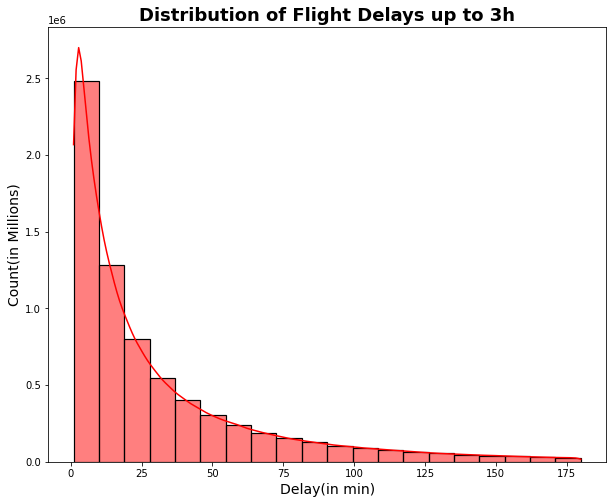

In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 05: Distribution of flights by Delay upto 3 Hours
##################################################

# Delay time distribution 
delay_time = flights.filter((col("DepDelayMinutes") > 0) & (col("DepDelayMinutes") < 181))

# Convert PySpark DataFrame to Pandas DataFrame
delay_flights_pd = delay_time.select("DepDelayMinutes").toPandas()

# Plotting
plt.figure(figsize=(10,8))
sns.histplot(data=delay_flights_pd, x="DepDelayMinutes", bins=20, kde=True, color='red', edgecolor='black', linewidth=1.2)

# Setting the label for x-axis
plt.xlabel('Delay(in min)', size=14)
 
# Setting the label for y-axis
plt.ylabel("Count(in Millions)", size=14)
 
# Setting the title for the graph
plt.title("Distribution of Flight Delays up to 3h", fontsize=18, color='Black',fontweight='bold', loc = 'center')
 
# Finally showing the plot
plt.show()

In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 06: Analytics to calculate Delays upto 30 mins
##################################################

# Filter flights with departure delay between 1 and 30 minutes
delays0to30 = flights.filter((col("DepDelayMinutes") > 0) & (col("DepDelayMinutes") < 30))

# Calculate the total number of delays
delays_total = flights.filter(col("DepDelayMinutes") > 0).count()

# Calculate the number of delays between 0 and 30 minutes
delays0to30_count = delays0to30.count()

# Calculate the percentage of delays between 0 and 30 minutes compared to total delays
percentage_delays0to30 = (delays0to30_count / delays_total) * 100

print(f"Percentage of delays between 0 and 30 minutes: {percentage_delays0to30:.2f} ")


Percentage of delays between 0 and 30 minutes: 65.28 


In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 07: Analytics to calculate total percent of Delayed flights in the dataset
##################################################


flights_on_time = flights.filter(col("DelayGroup") == 'OnTime_Early').select(count("FlightDate")).collect()[0][0]

# Count the total number of flights
total_flights = flights.filter(col('FlightDate').isNotNull()).count()

# Calculate the percentage of delayed flights
percentage_delayed_flights = 100 - (flights_on_time / total_flights * 100)

print(f"The total percentage of flights that got delayed from 2018-2022 is  {percentage_delayed_flights:.2f} ")

The total percentage of flights that got delayed from 2018-2022 is  25.83 


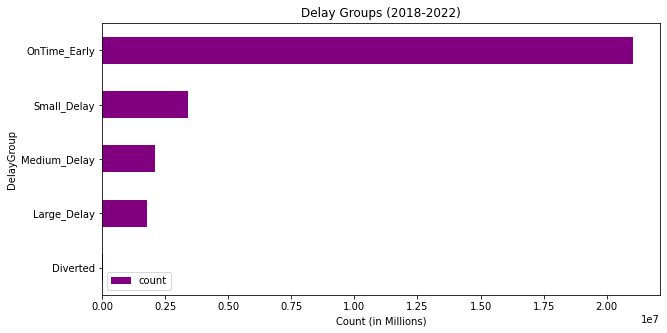

In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 08: Delay Group Clustering
##################################################


# Create a new column 'DelayGroup' with default value None
flights = flights.withColumn("DelayGroup", lit(None))

# Define conditions and corresponding values for each delay group
conditions = [
    (col("DepDelayMinutes") == 0, "OnTime_Early"),
    ((col("DepDelayMinutes") > 0) & (col("DepDelayMinutes") <= 15), "Small_Delay"),
    ((col("DepDelayMinutes") > 15) & (col("DepDelayMinutes") <= 45), "Medium_Delay"),
    (col("DepDelayMinutes") > 45, "Large_Delay"),
    (col("Cancelled"), "Cancelled"),
    (col("Diverted"), "Diverted")
]

# Iterate through conditions and apply when condition to set DelayGroup
for condition in conditions:
    flights = flights.withColumn("DelayGroup", when(condition[0], condition[1]).otherwise(col("DelayGroup")))

# Group by DelayGroup and count occurrences
delay_group_counts = flights.groupBy("DelayGroup").count().orderBy("count")

# Convert to Pandas DataFrame for plotting
delay_group_counts_pd = delay_group_counts.toPandas()

# Plotting
delay_group_counts_pd.plot(kind="barh", x="DelayGroup", y="count", figsize=(10, 5), color='purple', title="Delay Groups (2018-2022)")
plt.xlabel("Count (in Millions)")
plt.show()


In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 09: Analytics and Visualization for Treemap of Delays by Year
##################################################

# Group flights by year and delay group, and calculate the percentage of each delay group
flights_agg = flights.groupBy("Year", "DelayGroup").agg((count("*") / flights.count() * 100).alias("Percentage"))

# Pivot the data to get DelayGroup as columns
flights_agg = flights_agg.groupBy("Year").pivot("DelayGroup").agg(F.first("Percentage")).fillna(0)

# Define the order of columns
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Diverted"]

# Reorder the columns
flights_agg = flights_agg.select("Year", *col_order)

# Order the years in ascending order
flights_agg = flights_agg.orderBy("Year")

# Convert to Pandas DataFrame
flights_agg_pd = flights_agg.toPandas()

# Set the 'Year' column as the index label
flights_agg_pd.set_index('Year', inplace=True)

# Apply background gradient
flights_agg_pd_styled = flights_agg_pd.style.background_gradient(cmap='Purples')

# Display the styled DataFrame
display(flights_agg_pd_styled)


,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Diverted
Year,,,,,
2018,14.143186,2.550866,1.610274,1.343507,0.041172
2019,20.288300,3.451339,2.157462,1.978246,0.061626
2020,14.101454,1.335838,0.659237,0.501440,0.026288
2021,16.066665,2.737191,1.654433,1.322758,0.047809
2022,9.572959,1.926076,1.308758,1.080869,0.032248


In [0]:
##################################################
## SECTION 04: Data Analytics and Visualization
##
## Step 10: Analytics and Visualization for Treemap of Delays by Month
##################################################

# Group by Month and DelayCategory, calculate counts, and normalize
flights_agg = flights.groupBy("Month", "DelayGroup").count().alias("count_per_category")
total_counts = flights_agg.groupBy("Month").agg({"count": "sum"}).withColumnRenamed("sum(count)", "total_count")
flights_agg = flights_agg.join(total_counts, "Month")
flights_agg = flights_agg.withColumn("percentage", col("count") / col("total_count") * 100)

# Pivot the DataFrame to have DelayCategory as columns
flights_pivot = flights_agg.groupBy("Month").pivot("DelayGroup").agg({"percentage": "sum"}).fillna(0)

# Order months in ascending order
flights_pivot = flights_pivot.orderBy("Month")

# Reorder columns
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Diverted"]
flights_pivot = flights_pivot.select("Month", *col_order)

# Optionally, you can convert the result DataFrame to Pandas DataFrame for styling
flights_pandas = flights_pivot.toPandas()

# Set the 'Year' column as the index label
flights_pandas.set_index('Month', inplace=True)

# Apply background gradient using Pandas styling
styled_df = flights_pandas.style.background_gradient(cmap="Purples")
display(styled_df)

,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Diverted
Month,,,,,
1,76.448351,11.098535,6.673394,5.612414,0.167306
2,73.753842,12.172056,7.575778,6.317198,0.181126
3,76.310485,11.557466,6.814638,5.165712,0.151699
4,75.304322,11.651351,7.044466,5.810703,0.189158
5,72.859250,12.724239,7.717663,6.445658,0.253190
6,68.468087,13.417958,9.196832,8.610717,0.306405
7,70.346613,12.644946,8.583246,8.111743,0.313452
8,72.568075,11.872968,7.764463,7.510037,0.284458
9,78.873628,10.524675,5.712691,4.713803,0.175202
